In [2]:
import psycopg2
import os
import requests
import time
import shapely.wkb
import shapely.ops
import sys
import pyproj
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats
from functools import partial

In [3]:
# setup postgis connecton funcitons
pg_user=os.environ.get('POSTGIS_ENV_POSTGRES_USER')
pg_pass=os.environ.get('POSTGIS_ENV_POSTGRES_PASSWORD')
pg_host=os.environ.get('POSTGIS_PORT_5432_TCP_ADDR')
pg_port=os.environ.get('POSTGIS_PORT_5432_TCP_PORT')

def postgis(query):
    conn = psycopg2.connect(user=pg_user,
                            password=pg_pass,
                            host=pg_host,
                            port=pg_port)
    cur = conn.cursor()
    cur.execute(query)
    r = list(cur.fetchall())
    cur.close()
    conn.close()
    return r

In [4]:
# setup carto connection funcitons
CARTO_URL = 'https://{}.carto.com/api/v2/sql'
CARTO_USER = 'wri-01'
CARTO_KEY = os.environ.get('CARTO_KEY')

def sendSql(sql, user=None, key=None):
    '''Send arbitrary sql and return response object or False'''
    user = user or CARTO_USER
    key = key or CARTO_KEY
    url = CARTO_URL.format(user)
    payload = {
        'api_key': key,
        'q': sql,
    }
    r = requests.post(url, json=payload)
    if (r.status_code >= 400):
        try:
            msg = r.json()['error'][0]
        except:
            r.raise_for_status()
        raise Exception(msg)
    return r.json()

In [5]:
# shapely + pyproj area calculation
def areaEqual(geom):
    # Equal-area approx equiv to ST_AREA(geog) a la sgilles
    return shapely.ops.transform(
        partial(
            pyproj.transform,
            pyproj.Proj(init='EPSG:4326'),
            pyproj.Proj(
                proj='aea', # Albers equal area
                lat_1=geom.bounds[1],
                lat_2=geom.bounds[3])
        ), geom).area

def loadGeoms(rows, geom_field='the_geom'):
    return [shapely.wkb.loads(r[geom_field], hex=True) for r in rows if r[geom_field]]

# Test simplify tolerances

/home/notebooks/.local/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:5252: RuntimeWarning: overflow encountered in power
  Px /= np.sqrt(r*np.pi)*(1+(x**2)/r)**((r+1)/2)


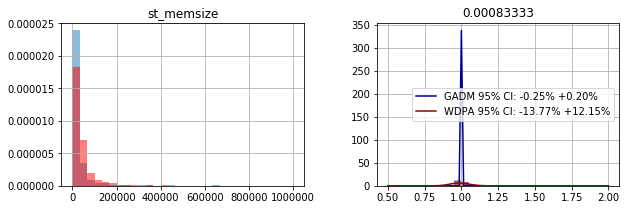

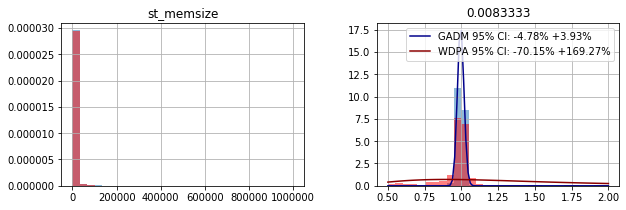

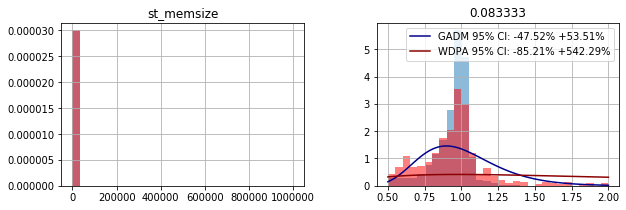

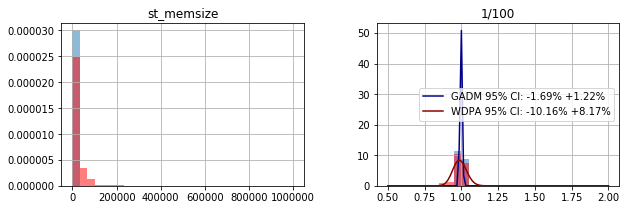

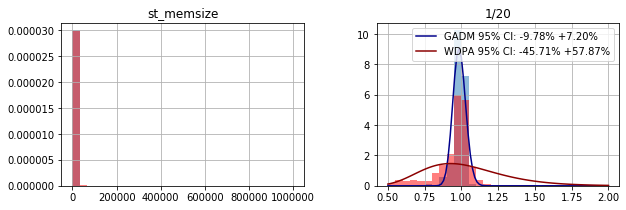

In [133]:
# test simplify tolerances for most complex geoms
tolerances = [
    0.00083333, #3sec ~100m
    0.0083333, #30sec ~1km
    0.083333, #5min ~10km
    '1/100', # tolerance at sqrt(area)/100
    '1/20', # tolerance at sqrt(area)/20
]
base_query = """
select 
    cartodb_id, 
    ST_MEMSIZE({}), 
    ST_AREA({}) as simp_area, 
    ST_AREA(the_geom) as area
from {} order by ST_MEMSIZE(the_geom) desc limit 1000
"""
gadm_table2 = 'gadm36_adm2'
wdpa_table = 'wdpa_protected_areas'
for t in tolerances:
    if t=='1/100':
        simp = "ST_SIMPLIFY(the_geom, SQRT(ST_AREA(the_geom))/100.0)"
    elif t=='1/20':
        simp = "ST_SIMPLIFY(the_geom, SQRT(ST_AREA(the_geom))/20.0)"
    elif t:
        simp = "ST_SIMPLIFY(the_geom, {})".format(t)
    else:
        simp = 'the_geom'
    
    query = base_query.format(simp, simp, gadm_table2)
    gadm_df=pd.DataFrame(sendSql(query)['rows'])
    gadm_df['area_err'] = gadm_df['simp_area']/gadm_df['area']
    gadm_df['ln_area_err'] = np.log(gadm_df['simp_area']/gadm_df['area'])
    
    query = base_query.format(simp, simp, wdpa_table)
    wdpa_df=pd.DataFrame(sendSql(query)['rows'])
    wdpa_df['area_err'] = wdpa_df['simp_area']/wdpa_df['area']
    wdpa_df['ln_area_err'] = np.log(wdpa_df['simp_area']/wdpa_df['area'])

    fig, axs = plt.subplots(1,2, figsize=(10,3))
    gadm_df.hist('st_memsize', range=(0, 1000000), ax=axs[0], alpha=.5, density=True, bins=30)
    wdpa_df.hist('st_memsize', range=(0, 1000000), ax=axs[0], color='r', alpha=.5, density=True, bins=30)

    x = np.linspace(.5, 2, 100)


    gadm_df.hist('area_err', range=(.5, 2), ax=axs[1], alpha=.5, density=True, bins=30)
    err = gadm_df[gadm_df['ln_area_err'].notna()]['ln_area_err']
    dof = len(err)-1
    mu = err.mean()
    sigma = err.std(ddof=1)
    y = scipy.stats.t.pdf(np.log(x), dof, mu, sigma)
    ci = (np.exp(scipy.stats.t.interval(.95, dof, mu, sigma))-1)*100
    axs[1].plot(x, y, color='darkblue', label="GADM 95% CI: {:.2f}% +{:.2f}%".format(ci[0], ci[1]))
    
    wdpa_df.hist('area_err', range=(.5, 2), ax=axs[1], color='r', alpha=.5, density=True, bins=30)
    err = wdpa_df[wdpa_df['ln_area_err'].notna()]['ln_area_err']
    dof = len(err)-1
    mu = err.mean()
    sigma = err.std(ddof=1)
    y = scipy.stats.t.pdf(np.log(x), dof, mu, sigma)
    ci = (np.exp(scipy.stats.t.interval(.95, dof, mu, sigma))-1)*100
    axs[1].plot(x, y, color='darkred', label="WDPA 95% CI: {:.2f}% +{:.2f}%".format(ci[0], ci[1]))

    plt.legend()
    plt.title(t)


# Profile carto queries

In [ ]:
# vars
gadm_table2 = 'gadm36_adm2'
wdpa_table = 'wdpa_protected_areas'

query = """
select cartodb_id, gid_2 from {} where gid_2 in ('USA.2.13_1', 'USA.2.18_1', 'USA.2.2_1')
""".format(gadm_table2)
ids = [r['cartodb_id'] for r in sendSql(query)['rows']]
tolerance = 0.00083333

In [132]:
# simplify only query polygon
query = """
    EXPLAIN (ANALYZE, FORMAT YAML) (
    SELECT
        ST_INTERSECTION(a.the_geom, b.the_geom) AS the_geom
    FROM {} AS a, (
        SELECT ST_MAKEVALID(ST_SIMPLIFY(the_geom, {tolerance})) AS the_geom
        FROM {} WHERE cartodb_id = {}
    ) AS b
    WHERE st_intersects(a.the_geom, b.the_geom))
""".format(wdpa_table, gadm_table2, ids[0], tolerance=0.00833333)
print(sendSql(query)['rows'][0]['QUERY PLAN'])

- Plan: 
    Node Type: "Nested Loop"
    Parallel Aware: false
    Join Type: "Inner"
    Startup Cost: 5.85
    Total Cost: 988.73
    Plan Rows: 73
    Plan Width: 32
    Actual Startup Time: 12102.018
    Actual Total Time: 21943.083
    Actual Rows: 21
    Actual Loops: 1
    Inner Unique: false
    Plans: 
      - Node Type: "Index Scan"
        Parent Relationship: "Outer"
        Parallel Aware: false
        Scan Direction: "Forward"
        Index Name: "gadm36_adm2_copy_pkey"
        Relation Name: "gadm36_adm2"
        Alias: "gadm36_adm2"
        Startup Cost: 0.29
        Total Cost: 8.31
        Plan Rows: 1
        Plan Width: 18752
        Actual Startup Time: 0.042
        Actual Total Time: 0.046
        Actual Rows: 1
        Actual Loops: 1
        Index Cond: "(cartodb_id = 41007)"
        Rows Removed by Index Recheck: 0
      - Node Type: "Index Scan"
        Parent Relationship: "Inner"
        Parallel Aware: false
        Scan Direction: "NoMovement"
        I

In [133]:
# test only bounding boxes
query = """
    EXPLAIN (ANALYZE, FORMAT YAML) (
    SELECT
        ST_INTERSECTION(a.the_geom, b.the_geom) AS the_geom
    FROM {} AS a, (
        SELECT ST_MAKEVALID(ST_SIMPLIFY(the_geom, {tolerance})) AS the_geom
        FROM {} WHERE cartodb_id = {}
    ) AS b
    WHERE a.the_geom && b.the_geom)
""".format(wdpa_table, gadm_table2, ids[0], tolerance=0.00833333)
print(sendSql(query)['rows'][0]['QUERY PLAN'])

- Plan: 
    Node Type: "Nested Loop"
    Parallel Aware: false
    Join Type: "Inner"
    Startup Cost: 5.85
    Total Cost: 2373.68
    Plan Rows: 218
    Plan Width: 32
    Actual Startup Time: 1826.715
    Actual Total Time: 9825.898
    Actual Rows: 22
    Actual Loops: 1
    Inner Unique: false
    Plans: 
      - Node Type: "Index Scan"
        Parent Relationship: "Outer"
        Parallel Aware: false
        Scan Direction: "Forward"
        Index Name: "gadm36_adm2_copy_pkey"
        Relation Name: "gadm36_adm2"
        Alias: "gadm36_adm2"
        Startup Cost: 0.29
        Total Cost: 8.31
        Plan Rows: 1
        Plan Width: 18752
        Actual Startup Time: 0.030
        Actual Total Time: 0.033
        Actual Rows: 1
        Actual Loops: 1
        Index Cond: "(cartodb_id = 41007)"
        Rows Removed by Index Recheck: 0
      - Node Type: "Index Scan"
        Parent Relationship: "Inner"
        Parallel Aware: false
        Scan Direction: "NoMovement"
        I

In [134]:
# simplify both geometries
query = """
    EXPLAIN (ANALYZE, FORMAT YAML) (
    SELECT
        ST_INTERSECTION(
            ST_MAKEVALID(ST_SIMPLIFY(a.the_geom, {tolerance})),
            b.the_geom) AS the_geom
    FROM {} AS a, (
        SELECT ST_MAKEVALID(ST_SIMPLIFY(the_geom, {tolerance})) AS the_geom
        FROM {} WHERE cartodb_id = {}
    ) AS b
    WHERE a.the_geom && b.the_geom)
""".format(wdpa_table, gadm_table2, ids[0], tolerance=0.00833333)
print(sendSql(query)['rows'][0]['QUERY PLAN'])

- Plan: 
    Node Type: "Nested Loop"
    Parallel Aware: false
    Join Type: "Inner"
    Startup Cost: 5.85
    Total Cost: 3524.71
    Plan Rows: 218
    Plan Width: 32
    Actual Startup Time: 406.175
    Actual Total Time: 2928.605
    Actual Rows: 22
    Actual Loops: 1
    Inner Unique: false
    Plans: 
      - Node Type: "Index Scan"
        Parent Relationship: "Outer"
        Parallel Aware: false
        Scan Direction: "Forward"
        Index Name: "gadm36_adm2_copy_pkey"
        Relation Name: "gadm36_adm2"
        Alias: "gadm36_adm2"
        Startup Cost: 0.29
        Total Cost: 8.31
        Plan Rows: 1
        Plan Width: 18752
        Actual Startup Time: 0.059
        Actual Total Time: 0.064
        Actual Rows: 1
        Actual Loops: 1
        Index Cond: "(cartodb_id = 41007)"
        Rows Removed by Index Recheck: 0
      - Node Type: "Index Scan"
        Parent Relationship: "Inner"
        Parallel Aware: false
        Scan Direction: "NoMovement"
        In

# Profile local union ops

In [93]:
# test geoms for local union
test_geoms = []
for cdbid in ids:
    query = """
        SELECT
            ST_INTERSECTION(
                ST_MAKEVALID(ST_SIMPLIFY(a.the_geom, {tolerance})),
                b.the_geom) AS the_geom
        FROM {} AS a, (
            SELECT ST_MAKEVALID(ST_SIMPLIFY(the_geom, {tolerance})) AS the_geom
            FROM {} WHERE cartodb_id = {}
        ) AS b
        WHERE a.the_geom && b.the_geom
    """.format(wdpa_table, gadm_table2, cdbid, tolerance=tolerance)
    test_geoms.append( sendSql(query)['rows'] )

In [135]:
%%timeit -r 3 -n 1
## Profile union+area local postgis
for rows in test_geoms:
    geoms = ','.join(["'{}'::geometry".format(r['the_geom']) for r in rows if r['the_geom']])
    query = """
    SELECT ST_AREA(ST_UNION(ARRAY[{}])::geography, false) as area
    """.format(geoms)
    area = postgis(query)[0][0]

158 ms ± 17.2 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)


In [136]:
%%timeit -r 3 -n 1
## Profile union+area shapely + pyproj
for rows in test_geoms:
    geoms = loadGeoms(rows)
    union_geoms = shapely.ops.unary_union(geoms)
    area = areaEqual(union_geoms)

849 ms ± 22.6 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)


# Etc...

In [15]:
gadm_table3 = 'gadm36_adm2'
worst_case_ids = ['AUS.11.137_1',
 'BEL.3.3_1',
 'BRA.15.215_1',
 'BRA.15.219_1',
 'BRA.15.220_1',
 'BRA.16.55_1',
 'CAN.8.1_1',
 'CAN.8.3_1',
 'CAN.11.84_1',
 'DEU.4.18_1',
 'DEU.8.1_1',
 'DEU.8.2_1',
 'DEU.10.13_1',
 'DEU.10.21_1',
 'DEU.10.27_1',
 'DEU.10.43_1',
 'DEU.14.11_1',
 'DNK.2.3_1',
 'DNK.3.3_1',
 'DNK.3.4_1',
 'DNK.5.19_1',
 'ESP.3.1_1',
 'ESP.6.3_1',
 'ESP.11.1_1',
 'ESP.11.2_1',
 'ESP.14.2_1',
 'FIN.2.1_1',
 'FIN.5.3_1',
 'FRA.1.10_1',
 'FRA.10.11_1',
 'GBR.1.22_1',
 'GBR.3.4_1',
 'GBR.3.17_1',
 'GBR.4.17_1',
 'GTM.7.30_1',
 'IDN.14.7_1',
 'IDN.14.13_1',
 'NGA.12.4_1']
query = """
select 
    cartodb_id, gid_2, the_geom, 
    ST_MEMSIZE(the_geom), 
    ST_AREA(the_geom::geography), 
    SQRT(ST_AREA(the_geom::geometry)) as est_edge 
from {} where gid_2 in ({})
""".format(gadm_table2, ','.join(["'{}'".format(i) for i in worst_case_ids]))
worst_df=pd.DataFrame(sendSql(query)['rows'])
worst_df

,cartodb_id,est_edge,gid_2,st_area,st_memsize,the_geom
0,14108,1.501584,ESP.11.1_1,2.177052e+10,83472,0106000020E6100000010000000103000000010000005E...
1,14109,1.444515,ESP.11.2_1,1.986626e+10,64192,0106000020E610000001000000010300000001000000A9...
2,14439,1.333390,FIN.5.3_1,1.087166e+10,1353664,0106000020E6100000620600000103000000010000002D...
3,1808,3.072234,AUS.11.137_1,1.120223e+11,728848,0106000020E61000005404000001030000000100000012...
4,11473,0.863079,DEU.8.2_1,5.495834e+09,57904,0106000020E61000000100000001030000000100000020...
5,11538,0.398172,DEU.10.13_1,1.250297e+09,21584,0106000020E61000000100000001030000000100000042...
6,14531,0.923204,FRA.10.11_1,7.688884e+09,30920,0106000020E6100000010000000103000000030000005F...
7,16972,0.825838,IDN.14.7_1,8.386659e+09,9280,0106000020E61000000100000001030000000100000041...
8,16978,1.163040,IDN.14.13_1,1.663553e+10,17376,0106000020E6100000010000000103000000010000003B...
9,14470,0.962314,FRA.1.10_1,8.012234e+09,6576,0106000020E61000000100000001030000000100000098...


In [16]:
tolerances = [
    0, #
    0.00083333, #3sec ~100m
    0.0083333, #30sec ~1km
    0.083333, #5min ~10km
    '1/100', # tolerance at sqrt(area)/100
    '1/20', # tolerance at sqrt(area)/20
]

for t in tolerances:
    area_col = "area_{}".format(t)
    if not area_col in worst_df.columns:
        worst_df[area_col] = np.nan 
    
    for i, cdbid in worst_df[worst_df[area_col].isna()]['cartodb_id'].iteritems():
        if t == '1/100':
            tolerance = worst_df.iloc[i]['est_edge']/100
            simp = "ST_MAKEVALID(ST_SIMPLIFY(the_geom, {}, true))".format(tolerance)
        elif t == '1/20':
            tolerance = worst_df.iloc[i]['est_edge']/20
            simp = "ST_MAKEVALID(ST_SIMPLIFY(the_geom, {}, true))".format(tolerance)
        elif t:
            simp = "ST_MAKEVALID(ST_SIMPLIFY(the_geom, {}, true))".format(t)
        else:
            simp = 'ST_MAKEVALID(the_geom)'

        query = """
            SELECT
                ST_INTERSECTION({simp}, ST_ENVELOPE(query_geom)) as the_geom
            FROM {}, (
                SELECT {simp} AS query_geom
                FROM {} WHERE cartodb_id = {}
            ) as b
            WHERE the_geom && query_geom
        """.format(wdpa_table, gadm_table2, cdbid, simp=simp)
        
        try:
            rows = sendSql(query)['rows']
            geoms = ','.join(["'{}'".format(r['the_geom']) for r in rows if r['the_geom']])

            query_geom = "'{}'".format(worst_df.iloc[i]['the_geom'])
            query_geom = simp.replace('the_geom', query_geom)
            
            query = """
            SELECT ST_AREA(ST_UNION((
                SELECT array_agg(ST_INTERSECTION( {}, the_geom ))
                FROM UNNEST(ARRAY[{}]::geometry[]) AS the_geom
            ))::geography, false) as area
            """.format(query_geom, geoms)

            area = postgis(query)[0][0] or 0
            worst_df.at[i, area_col] = area
            
            sys.stdout.write("{}: {} m3               \r".format(i, area))
            sys.stdout.flush()
        except Exception as e:
            print((i, e))

worst_df

(4, Exception("You are over platform's limits: SQL query timeout error. Refactor your query before running again or contact CARTO support for more details."))
(18, Exception("You are over platform's limits: SQL query timeout error. Refactor your query before running again or contact CARTO support for more details."))
(31, Exception("You are over platform's limits: SQL query timeout error. Refactor your query before running again or contact CARTO support for more details."))
(4, Exception("You are over platform's limits: SQL query timeout error. Refactor your query before running again or contact CARTO support for more details."))
(6, InternalError_('GEOSUnaryUnion: TopologyException: Input geom 0 is invalid: Self-intersection at or near point -0.19302970416262014 43.060000000000002 at -0.19302970416262014 43.060000000000002\n'))
(18, Exception("You are over platform's limits: SQL query timeout error. Refactor your query before running again or contact CARTO support for more details."))

,cartodb_id,est_edge,gid_2,st_area,st_memsize,the_geom,area_0,area_0.00083333,area_0.0083333,area_0.083333,area_1/100,area_1/20
0,14108,1.501584,ESP.11.1_1,2.177052e+10,83472,0106000020E6100000010000000103000000010000005E...,5.514990e+09,5.509495e+09,5.580165e+09,6.323855e+09,5.672057e+09,6.156213e+09
1,14109,1.444515,ESP.11.2_1,1.986626e+10,64192,0106000020E610000001000000010300000001000000A9...,7.252562e+09,7.256221e+09,7.274408e+09,8.261600e+09,7.401326e+09,8.158111e+09
2,14439,1.333390,FIN.5.3_1,1.087166e+10,1353664,0106000020E6100000620600000103000000010000002D...,3.595600e+05,3.112670e+05,7.204480e+05,4.200041e+05,2.121269e+05,4.322107e+05
3,1808,3.072234,AUS.11.137_1,1.120223e+11,728848,0106000020E61000005404000001030000000100000012...,3.609868e+10,3.113996e+10,4.417873e+10,4.155295e+10,3.623804e+10,4.065903e+10
4,11473,0.863079,DEU.8.2_1,5.495834e+09,57904,0106000020E61000000100000001030000000100000020...,NaN,NaN,NaN,NaN,NaN,NaN
5,11538,0.398172,DEU.10.13_1,1.250297e+09,21584,0106000020E61000000100000001030000000100000042...,9.249999e+08,9.274383e+08,8.178751e+08,6.300466e+08,8.827292e+08,7.268608e+08
6,14531,0.923204,FRA.10.11_1,7.688884e+09,30920,0106000020E6100000010000000103000000030000005F...,2.387626e+09,NaN,2.826006e+09,3.257546e+09,2.898277e+09,3.459728e+09
7,16972,0.825838,IDN.14.7_1,8.386659e+09,9280,0106000020E61000000100000001030000000100000041...,1.983856e+09,1.988989e+09,2.009682e+09,2.354889e+09,2.009682e+09,1.957017e+09
8,16978,1.163040,IDN.14.13_1,1.663553e+10,17376,0106000020E6100000010000000103000000010000003B...,2.248491e+09,2.248078e+09,2.249517e+09,2.181410e+09,2.275352e+09,2.320853e+09
9,14470,0.962314,FRA.1.10_1,8.012234e+09,6576,0106000020E61000000100000001030000000100000098...,4.693329e+09,4.712684e+09,4.721581e+09,4.565782e+09,4.713991e+09,4.792187e+09


area_0.00083333 -0.00023030805524278946 0.08548894403949803
area_0.0083333 0.003531287210309203 0.23298963365858338
area_0.083333 0.022038981896069024 0.47112187110617243
area_1/100 -0.007061713749787447 0.2108382537362319
area_1/20 0.009661254357219196 0.2528238417887933


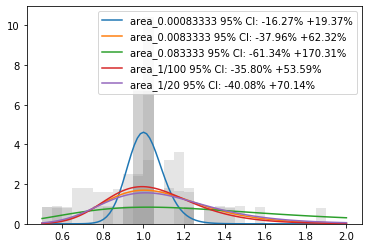

area_0.00083333 0.0002753885216248989 0.01201304317260049
area_0.0083333 -0.005898923078923176 0.045927799615240926
area_0.083333 -0.01766690064351875 0.0900979995797819
area_1/100 -0.0008518862806665211 0.0439028574586609
area_1/20 0.0028416310458329068 0.054606542537725504
1/100 0.008621506904403142
1/20 0.04310753452201571


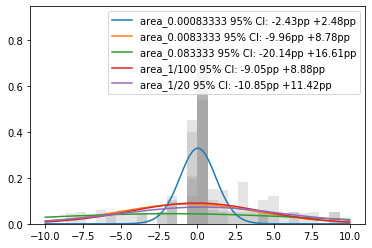

In [148]:
actual = worst_df['area_0']
tolerances = [
    0.00083333, #3sec ~100m
    0.0083333, #30sec ~1km
    0.083333, #5min ~10km
    '1/100', # tolerance at sqrt(area)/100
    '1/20', # tolerance at sqrt(area)/20
]
for t in tolerances:
    area_col = "area_{}".format(t)
    err = worst_df[area_col] / actual
    ln_err = np.log(err)
    ln_err = ln_err[ln_err.notna()]
    dof = len(ln_err)-1
    mu = np.mean(ln_err)
    sigma = np.std(ln_err, ddof=1)
    print(area_col, mu, sigma)
    x = np.linspace(.5, 2, 100)
    y = scipy.stats.t.pdf(np.log(x), dof, mu, sigma)
    ci = (np.exp(scipy.stats.t.interval(.95, dof, mu, sigma))-1)*100;
    plt.hist(err[err.notna()], range=[.5, 2], color='gray', alpha=.2, bins=30, density=True)
    plt.plot(x, y, label="{} 95% CI: {:.2f}% +{:.2f}%".format(area_col, ci[0], ci[1]))
    plt.legend()

plt.show()
actual = worst_df['area_0']/worst_df['st_area']
for t in tolerances:
    area_col = "area_{}".format(t)
    err = (worst_df[area_col]/worst_df['st_area']) - actual
    err = err[err.notna()]
    dof = len(err)-1
    mu = np.mean(err)
    sigma = np.std(err, ddof=1)
    print(area_col, mu, sigma)
    x = np.linspace(-.1, .1, 100)
    y = scipy.stats.t.pdf(x, dof, mu, sigma)/100
    ci = scipy.stats.t.interval(.95, dof, mu, sigma)
    plt.hist(err*100, range=[-10, 10], color='gray', alpha=.2, bins=30, density=True)
    plt.plot(x*100, y, label="{} 95% CI: {:.2f}pp +{:.2f}pp".format(area_col, ci[0]*100, ci[1]*100))
    plt.legend()

    
print('1/100', (worst_df['est_edge']/100).mean())
print('1/20', (worst_df['est_edge']/20).mean())

In [150]:
tolerances = [
    0.00083333, #3sec ~100m
    0.0083333, #30sec ~1km
    0.083333, #5min ~10km
    '1/100', # tolerance at sqrt(area)/100
    '1/20', # tolerance at sqrt(area)/20
]

percentages = pd.DataFrame()
percentages['area_0'] = worst_df[area_col]/worst_df['st_area']
for t in tolerances:
    area_col = "area_{}".format(t)
    percentages[area_col] = (worst_df['area_0']-worst_df[area_col])/worst_df['st_area']
    
percentages.sort_values('area_0').round(3)*100

,area_0,area_0.00083333,area_0.0083333,area_0.083333,area_1/100,area_1/20
20,0.0,0.0,0.0,0.0,0.0,0.0
24,0.0,0.0,0.0,0.0,0.0,0.0
26,0.0,0.0,0.0,0.0,0.0,0.0
14,0.0,0.0,0.0,0.0,0.0,0.0
13,0.0,0.0,0.0,0.0,0.0,0.0
12,0.0,0.0,0.0,0.0,0.0,0.0
11,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,-0.0,-0.0,0.0,-0.0
28,0.6,-0.0,0.4,-2.9,0.1,0.5
17,0.9,-0.0,-0.0,0.3,0.1,0.6


In [18]:
%%timeit -r 1
query = """
SELECT ST_AREA(
    ST_INTERSECTION( {},
        ST_UNION(ARRAY[{}]::geometry[])
    )::geography, false) as area
""".format(query_geom, geoms)
postgis(query)[0][0] or 0


103 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 10 loops each)


In [20]:
%%timeit -r 1
query = """
SELECT ST_AREA(ST_UNION((
    SELECT array_agg(ST_INTERSECTION( {}, the_geom ))
    FROM UNNEST(ARRAY[{}]::geometry[]) AS the_geom
))::geography, false) as area
""".format(query_geom, geoms)
postgis(query)[0][0] or 0


114 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 10 loops each)


In [53]:
%%timeit -r 1
query = """
SELECT ST_MAKEVALID(ST_SIMPLIFY(the_geom, .0083333))
FROM UNNEST(ARRAY[{}]::geometry[]) AS the_geom
""".format(['{}'.format(g) for g in worst_df['the_geom']])
postgis(query)[0][0] or 0

404 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [54]:
%%timeit -r 1
query = """
SELECT ST_MAKEVALID(ST_SIMPLIFY(the_geom, .0083333, true))
FROM UNNEST(ARRAY[{}]::geometry[]) AS the_geom
""".format(['{}'.format(g) for g in worst_df['the_geom']])
postgis(query)[0][0] or 0

1.42 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [56]:
%%timeit -r 1
query = """
SELECT ST_SIMPLIFYPRESERVETOPOLOGY(the_geom, .0083333)
FROM UNNEST(ARRAY[{}]::geometry[]) AS the_geom
""".format(['{}'.format(g) for g in worst_df['the_geom']])
postgis(query)[0][0] or 0

944 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [107]:
scipy.stats.t.fit?